In [3481]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats


%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [3482]:
inputdata1 = "../output_mo/combined_mo_data/" 
inputdata2 = "../output_qt/combined_qt_data/" #just to get gdp_total
outputdata1 = "../output_mo/regressiondata_mo/"

In [3483]:
def x_data():
    x_data = pd.read_csv(inputdata1 + "a0_combinedMonthly_extended_ARIMA.csv", index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date
    return x_data

### Change quarterly data to monthly using smoothing

In [3484]:
def y_data(seasonal=True):
    if seasonal:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)['gdp_total_deseasonalized'].to_frame()
    else:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)['gdp_total'].to_frame()

    first_date = y_data.index[0]
    y_data.index = pd.PeriodIndex(y_data.index, freq='Q')
    y_data['Date'] = y_data.index.to_timestamp()

    # convert to period
    y_data['Date'] = pd.to_datetime(y_data['Date']).dt.to_period('M')
    # set Date as index and resample
    y_data = y_data.set_index('Date').resample('M').interpolate()

    y_data.index = y_data.index.strftime('%Y-%m-%d')
    y_data.index = pd.date_range(first_date, y_data.index[-1], freq='MS').date
    return y_data


### Combine Y and X data

In [3485]:
regressionData = y_data(seasonal=False).merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv(outputdata1 + "regressiondata_mo.csv")
df1 = regressionData.iloc[0:355,:].copy()

df1.to_csv("tmp_df1.csv ")

In [3486]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))

In [3487]:
df1.columns.tolist()

['gdp_total',
 '^AEX',
 'ASML.AS',
 'AIR',
 'ING',
 'WKL.AS',
 'STLA',
 'AD.AS',
 'PHG',
 '^FVX',
 '^TNX',
 '^TYX',
 'Bankruptcies',
 'BusinessOutlook_Industry',
 'BusinessOutlook_Retail',
 'Consumentenvertrouwen_1',
 'EconomischKlimaat_2',
 'Koopbereidheid_3',
 'EconomischeSituatieLaatste12Maanden_4',
 'EconomischeSituatieKomende12Maanden_5',
 'FinancieleSituatieLaatste12Maanden_6',
 'FinancieleSituatieKomende12Maanden_7',
 'GunstigeTijdVoorGroteAankopen_8',
 'CPI_1',
 'CPIAfgeleid_2',
 'MaandmutatieCPI_3',
 'MaandmutatieCPIAfgeleid_4',
 'ProducerConfidence_1',
 'ExpectedActivity_2',
 'Crude oil, average',
 'Crude oil, Brent',
 'Crude oil, Dubai',
 'Crude oil, WTI',
 'Coal, Australian',
 'Coal, South African **',
 'Natural gas, US',
 'Natural gas, Europe',
 'Liquefied natural gas, Japan',
 'Natural gas index',
 'Cocoa',
 'Coffee, Arabica',
 'Coffee, Robusta',
 'Tea, avg 3 auctions',
 'Tea, Colombo',
 'Tea, Kolkata',
 'Tea, Mombasa',
 'Coconut oil',
 'Groundnuts',
 'Fish meal',
 'Groun

In [3488]:
# subset of the data
df1 = df1[['gdp_total', 
          '^AEX', 
          'ASML.AS',
          'AIR',
          'ING',
          'WKL.AS',
          'Bankruptcies',
          'Consumentenvertrouwen_1',
          'EconomischKlimaat_2',
          'Koopbereidheid_3',
          'EconomischeSituatieLaatste12Maanden_4',
          'EconomischeSituatieKomende12Maanden_5',
          'FinancieleSituatieLaatste12Maanden_6',
          'FinancieleSituatieKomende12Maanden_7',
          'GunstigeTijdVoorGroteAankopen_8',
          'CPI_1',
          'CPIAfgeleid_2',
          'ProducerConfidence_1', 
          'Crude oil, Brent',
          'Gold', 
          'M3_1', 
          'M3_2',
          'CCICP_NLD_CLI', 
          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
          'Natural gas, Europe', 
          'CCICP_DEU', 
          'United States_unemply_F',
          'United States_unemply_M', 
        ]]


In [3489]:
describe = df1.describe()
describe.loc['count',:].sort_values(ascending=True)

ASML.AS                                  313.0
CPI_1                                    343.0
CPIAfgeleid_2                            343.0
WKL.AS                                   353.0
AIR                                      355.0
ING                                      355.0
Bankruptcies                             355.0
^AEX                                     355.0
Consumentenvertrouwen_1                  355.0
EconomischKlimaat_2                      355.0
EconomischeSituatieLaatste12Maanden_4    355.0
Koopbereidheid_3                         355.0
EconomischeSituatieKomende12Maanden_5    355.0
FinancieleSituatieLaatste12Maanden_6     355.0
FinancieleSituatieKomende12Maanden_7     355.0
gdp_total                                355.0
GunstigeTijdVoorGroteAankopen_8          355.0
ProducerConfidence_1                     355.0
Crude oil, Brent                         355.0
Gold                                     355.0
M3_1                                     355.0
M3_2         

### Add 'sure' data and random data

In [3490]:
# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

### Standard Scaler

133228.0 187614.26197183097 26809.430507474917
133228.0


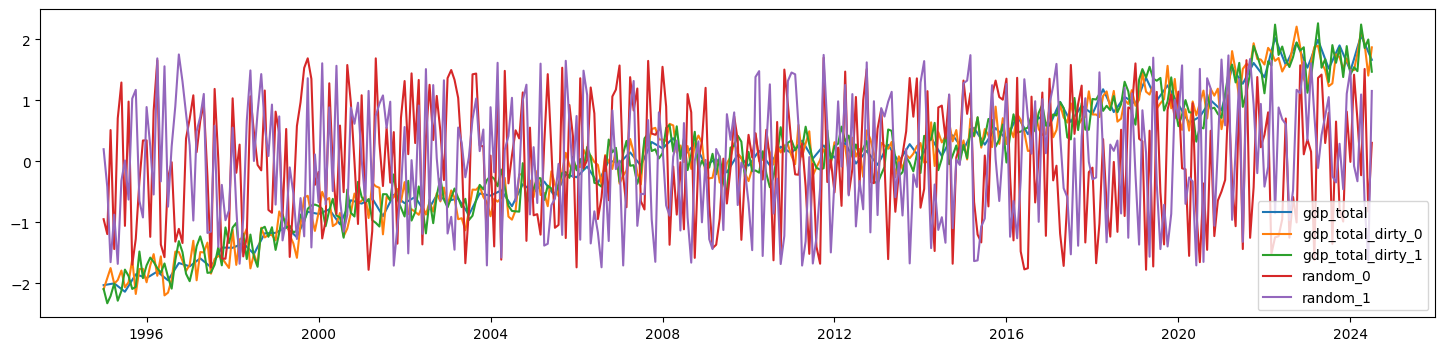

In [3491]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

# Needed to reform the data 
GDP_StandardScaler_firstValue = df1['gdp_total'][0]
GDP_StandardScaler_MEAN = np.mean(df1['gdp_total'].values)
GDP_StandardScaler_STD = np.std(df1['gdp_total'].values)
print(GDP_StandardScaler_firstValue, GDP_StandardScaler_MEAN, GDP_StandardScaler_STD)

print(scaled_features_df['gdp_total'][0] * GDP_StandardScaler_STD + GDP_StandardScaler_MEAN)

# assert GDP_StandardScaler_firstValue == scaled_features_df['gdp_total'][0] * GDP_StandardScaler_STD + GDP_StandardScaler_MEAN
# assert df1['gdp_total'][0] == scaler.inverse_transform(scaled_features_df)[0][0]



In [3492]:
def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
    return data * std + mean

std_inv_Transformation(scaled_features_df['gdp_total'][0])

np.float64(133228.0)

In [3493]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [3494]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:300,:]
    kw_test1['Months'] = [1,2,3,4,5,6,7,8,9,10,11,12] * int(len(kw_test1)/12)
    kw_test1['Semi'] = [1,2,3,4,5,6] * int(len(kw_test1)/6)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

In [3495]:
def Kruskal_Wallis_Monthly(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Months'].unique():
            res.append(data[data['Months'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Monthly_Seasonality'] = 'No_Monthly_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Monthly_Seasonality'] = 'Monthly_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Monthly(kw1, STORE_FOR_TESTS)
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
^AEX,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
ASML.AS,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
AIR,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
ING,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
WKL.AS,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
Bankruptcies,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
Koopbereidheid_3,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality


In [3496]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
ASML.AS,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
AIR,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
ING,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
WKL.AS,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
Bankruptcies,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
Koopbereidheid_3,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality


In [3497]:
#scaled_features_df[['Netherlands_unemply_F', 'United States_unemply_M', 'gdp_total']].plot()

In [3498]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)
scaled_features_df.dropna(inplace=True)

deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df.to_csv("tmp_scaled_features_df.csv ")

[ 2 14 19 28 29]
['AIR', 'CPI_1', 'M3_1', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


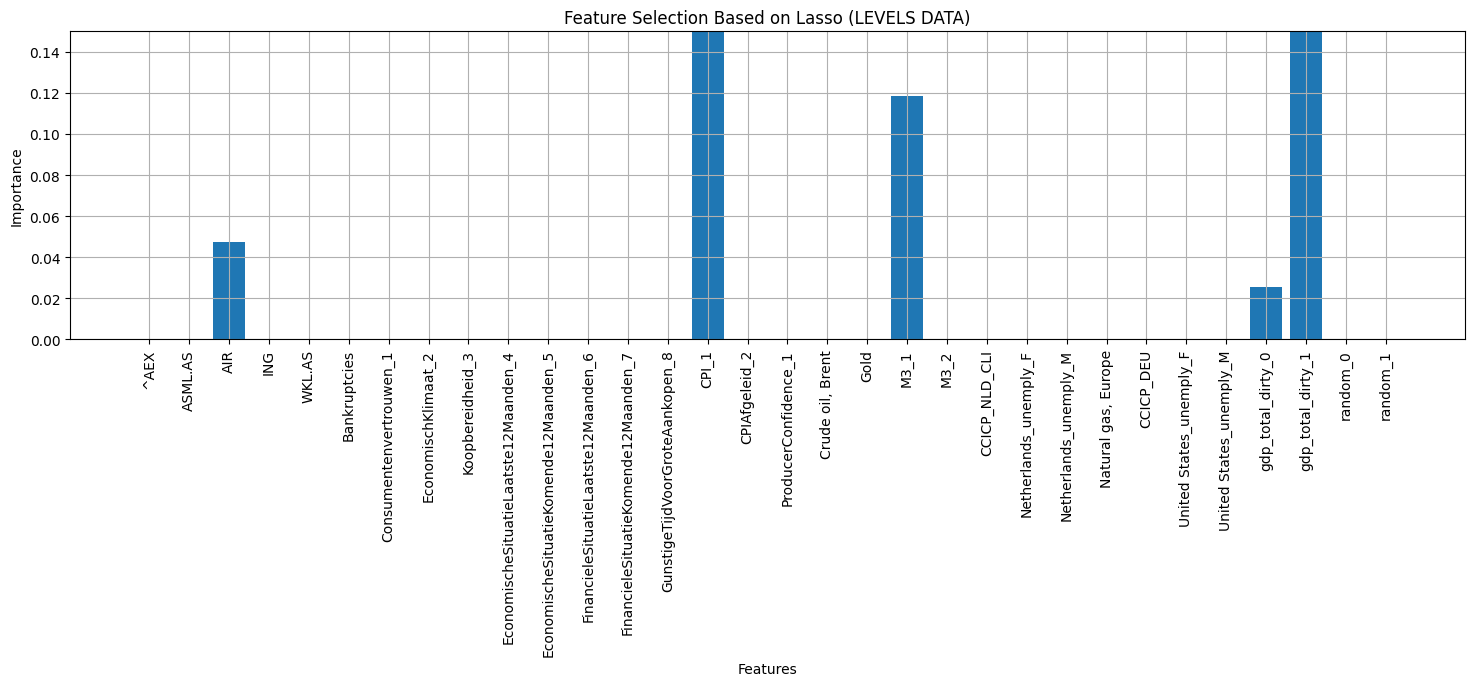

(313, 33)


In [3499]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.1, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
['^AEX', 'ASML.AS', 'AIR', 'ING', 'WKL.AS', 'Bankruptcies', 'Consumentenvertrouwen_1', 'EconomischKlimaat_2', 'Koopbereidheid_3', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'CPIAfgeleid_2', 'ProducerConfidence_1', 'Crude oil, Brent', 'Gold', 'M3_1', 'M3_2', 'CCICP_NLD_CLI', 'Netherlands_unemply_F', 'Netherlands_unemply_M', 'Natural gas, Europe', 'CCICP_DEU', 'United States_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


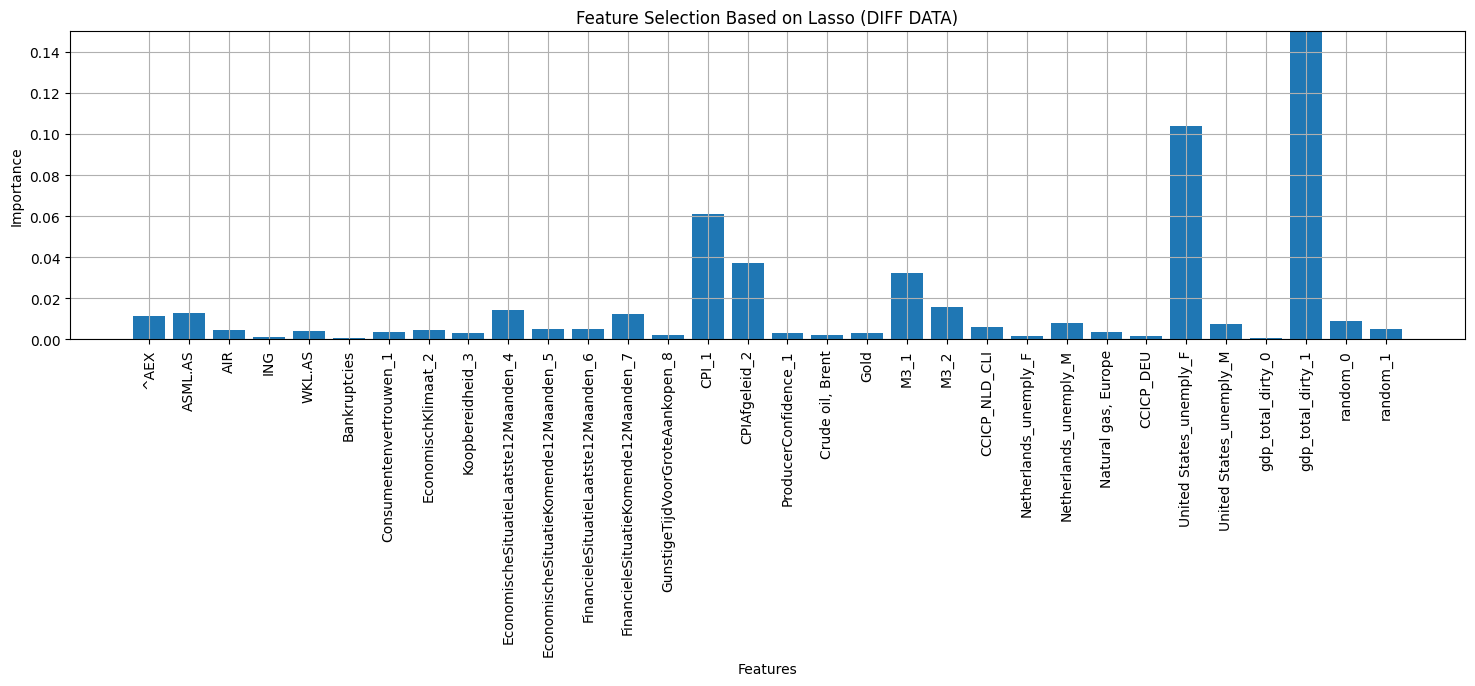

In [3500]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0, title='Feature Selection Based on Lasso (DIFF DATA)'); 

In [3501]:
def lag_data(data):
    # only returns lags of variables, not original data
    df1 = data.copy()
    number_lags = 1

    for lag in range(1, number_lags+1):
        for col in df1.columns:
            df1[col + '_lag_' + str(lag)] = df1[col].shift(lag)
        
    selectThese = [col for col in df1.columns if '_lag_' in col]
    df_lag = df1[selectThese]

    return df_lag

df_lag  = lag_data(scaled_features_df)
df_lag.insert(loc=0, column='gdp_total', value=scaled_features_df['gdp_total'])
df_lag

,gdp_total,gdp_total_lag_1,^AEX_lag_1,ASML.AS_lag_1,AIR_lag_1,ING_lag_1,WKL.AS_lag_1,Bankruptcies_lag_1,Consumentenvertrouwen_1_lag_1,EconomischKlimaat_2_lag_1,...,Netherlands_unemply_F_lag_1,Netherlands_unemply_M_lag_1,"Natural gas, Europe_lag_1",CCICP_DEU_lag_1,United States_unemply_F_lag_1,United States_unemply_M_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1998-07-01,-1.356938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-01,-1.330914,-1.356938,0.699685,-0.642080,0.007481,0.777928,-0.398453,-0.491333,1.660693,1.379290,...,-0.205179,-0.987254,-0.722345,0.275815,-0.464510,-0.677012,-1.518077,-1.356241,-0.184798,-0.119402
1998-09-01,-1.304889,-1.330914,0.384401,-0.643887,-0.214429,0.551570,-0.351308,-0.986556,1.527452,1.264498,...,-0.103164,-1.052398,-0.726194,0.411500,-0.479373,-0.687351,-1.690443,-1.325564,-0.154426,-0.134082
1998-10-01,-1.278865,-1.304889,-0.041451,-0.648834,-0.429303,0.068036,-0.307416,-0.088440,1.260971,0.834025,...,0.049858,-0.987254,-0.731326,0.519584,-0.494235,-0.697689,-1.086919,-1.294888,-0.124053,-0.148761
1998-11-01,-1.252840,-1.278865,-0.286237,-0.648995,-0.479092,-0.304713,-0.324112,-0.827077,0.816835,0.202666,...,0.049858,-0.987254,-0.751856,0.637242,-0.509097,-0.708028,-1.246454,-1.264212,-0.093680,-0.163441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,1.731004,1.732197,2.435320,3.449389,2.944948,0.483039,3.512859,-0.885832,-1.004122,-0.973959,...,-1.327345,-0.726677,0.015229,-0.821160,-1.069961,-0.845861,1.497518,1.667849,0.235494,0.193651
2024-04-01,1.729811,1.731004,2.558293,3.650255,2.865726,0.863057,3.578397,-0.906816,-0.782054,-0.801770,...,-1.429360,-0.856965,0.067238,-0.588237,-1.062534,-0.830772,1.776768,1.667107,0.243736,0.155722
2024-05-01,1.728618,1.729811,2.646212,3.539630,2.863475,1.096858,3.446905,-0.562679,-0.737641,-0.773072,...,-1.480367,-0.922109,0.135421,-0.327234,-1.055107,-0.815682,2.140688,1.666365,0.251979,0.117792
2024-06-01,1.727425,1.728618,2.831977,3.481241,3.422890,1.473182,3.660511,-0.915210,-0.782054,-0.887865,...,-1.531375,-0.922109,0.268600,-0.160224,-1.047680,-0.800593,1.924729,1.665623,0.260221,0.079862


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 18 19 20 24 25 26 27 29 30
 31 32]
['gdp_total_lag_1', '^AEX_lag_1', 'ASML.AS_lag_1', 'AIR_lag_1', 'ING_lag_1', 'WKL.AS_lag_1', 'Bankruptcies_lag_1', 'Consumentenvertrouwen_1_lag_1', 'EconomischKlimaat_2_lag_1', 'Koopbereidheid_3_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'CPI_1_lag_1', 'Crude oil, Brent_lag_1', 'Gold_lag_1', 'M3_1_lag_1', 'Netherlands_unemply_M_lag_1', 'Natural gas, Europe_lag_1', 'CCICP_DEU_lag_1', 'United States_unemply_F_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']


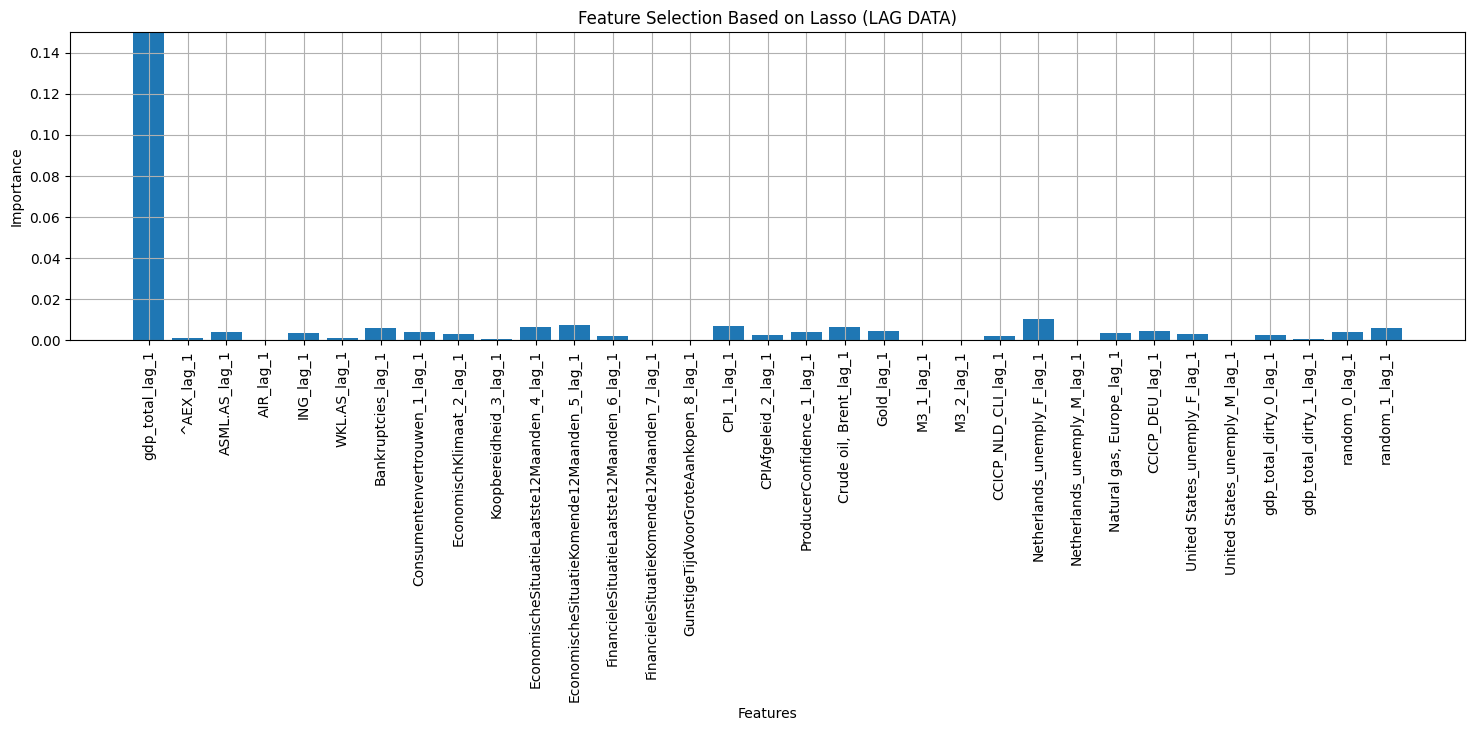

In [3502]:
lassoreg(df_lag, alpha=0.0001, title='Feature Selection Based on Lasso (LAG DATA)'); 

[ 0  3  4  6 17 18 24 25 26 27 29 30]
['gdp_total_lag_1', 'AIR_lag_1', 'ING_lag_1', 'Bankruptcies_lag_1', 'ProducerConfidence_1_lag_1', 'Crude oil, Brent_lag_1', 'Netherlands_unemply_M_lag_1', 'Natural gas, Europe_lag_1', 'CCICP_DEU_lag_1', 'United States_unemply_F_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1']


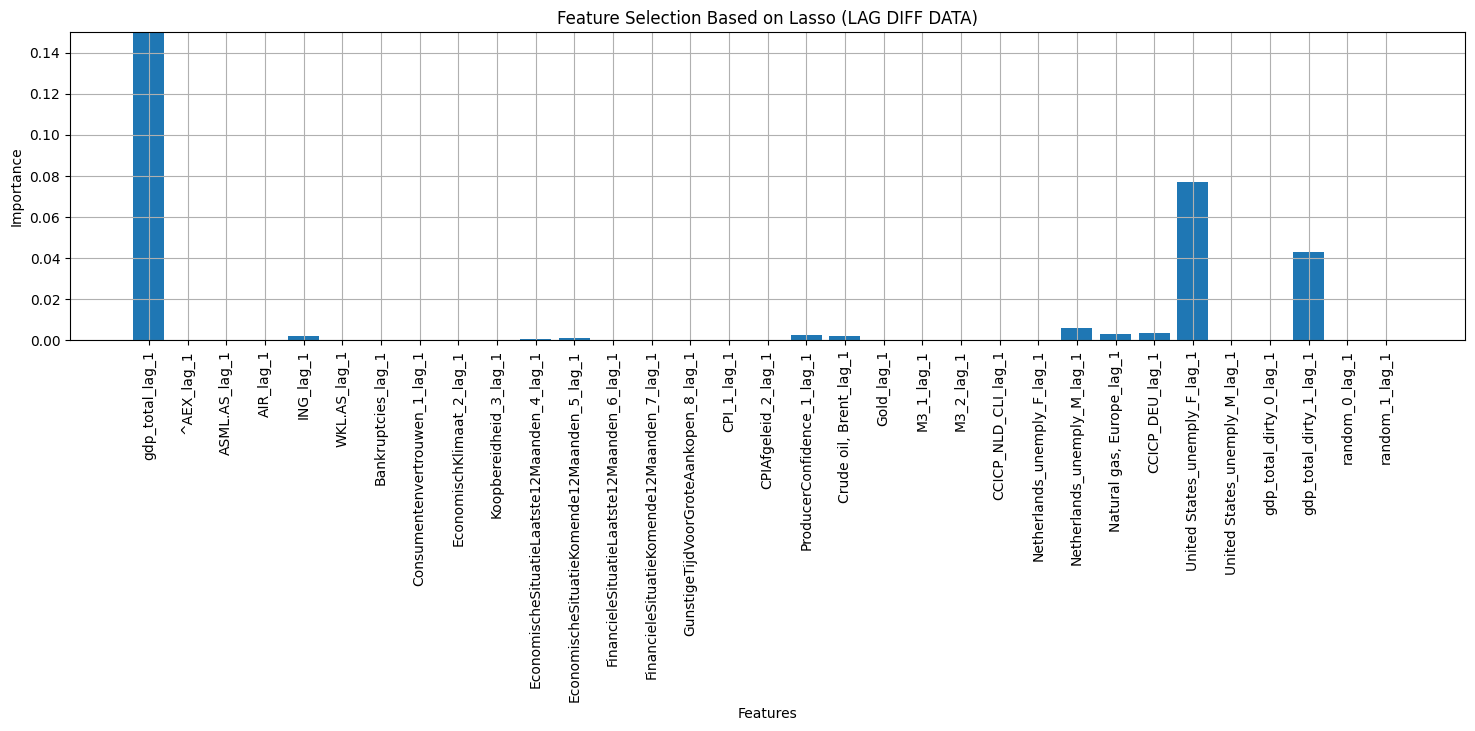

In [3503]:
lassoreg(df_lag.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (LAG DIFF DATA)'); 


### Make sure data is stationary

In [3504]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)

(33, 3)


### If not stationary, difference, then test for stationarity again

In [3505]:
def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    GDP_FIRST_VALUE_BEFORE_DIFFERENCE = originalData.iloc[0:1, 0]
    print(GDP_FIRST_VALUE_BEFORE_DIFFERENCE)

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS, GDP_FIRST_VALUE_BEFORE_DIFFERENCE

scaled_features_df_diff, STORE_FOR_TESTS, GDP_FIRST_VALUE_BEFORE_DIFFERENCE = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

print(scaled_features_df_diff.shape)


1998-07-01   -1.356938
Name: gdp_total, dtype: float64
(313, 33)


In [3506]:
def diff_inv_Transformation(df_diff, first_value):
    series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
    return series_inverted

test = diff_inv_Transformation(scaled_features_df_diff['gdp_total'].dropna(), GDP_FIRST_VALUE_BEFORE_DIFFERENCE)

#assert np.allclose(test, scaled_features_df['gdp_total'].dropna())

In [3507]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
ASML.AS,NaN,No_Semi_Seasonality,NotStationary,NotStationary,True,No_Monthly_Seasonality
AIR,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
ING,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
WKL.AS,NaN,No_Semi_Seasonality,NotStationary,NotStationary,True,No_Monthly_Seasonality
Bankruptcies,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Koopbereidheid_3,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality


<Axes: >

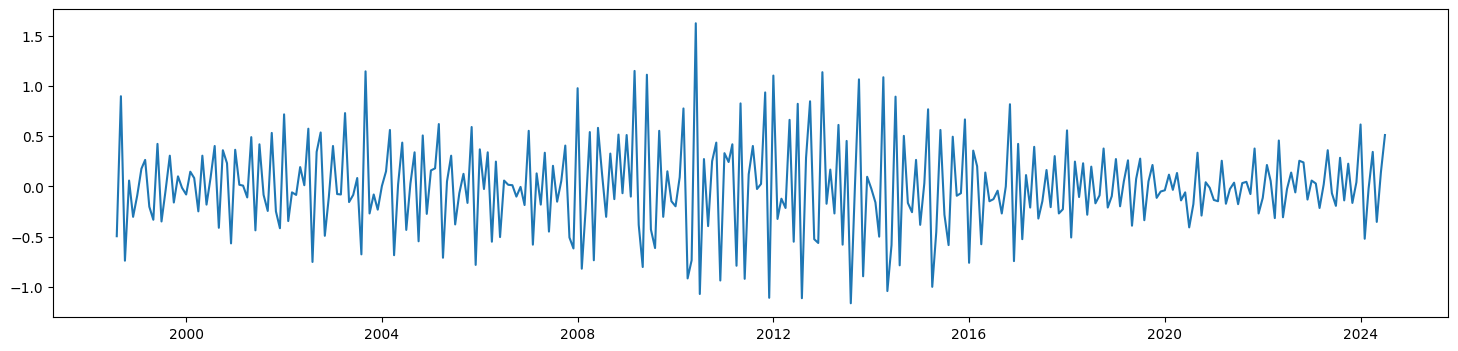

In [3508]:
scaled_features_df_diff['Bankruptcies'].plot()

[ 3  4 10 11 16 17 20 21 24 26 29]
['ING', 'WKL.AS', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'ProducerConfidence_1', 'Crude oil, Brent', 'M3_2', 'CCICP_NLD_CLI', 'Natural gas, Europe', 'United States_unemply_F', 'gdp_total_dirty_1']


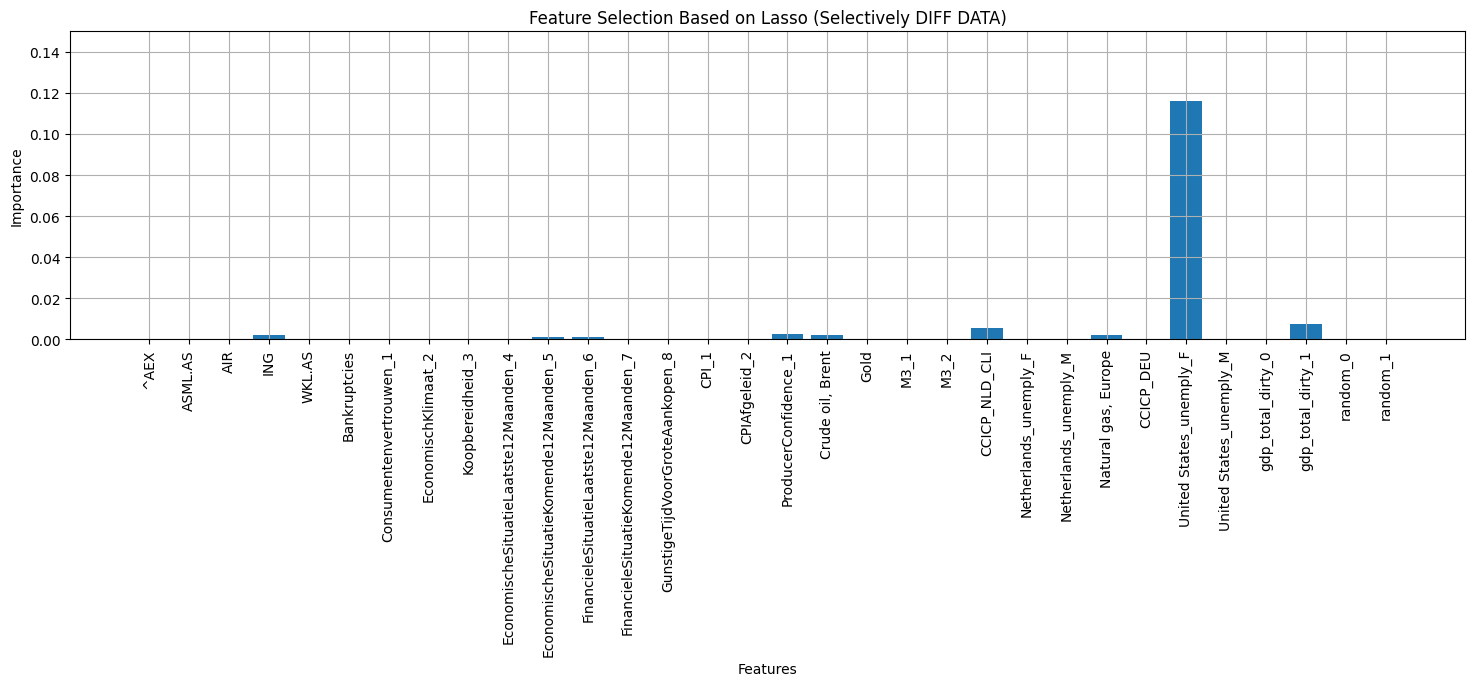

['ING',
 'WKL.AS',
 'EconomischeSituatieKomende12Maanden_5',
 'FinancieleSituatieLaatste12Maanden_6',
 'ProducerConfidence_1',
 'Crude oil, Brent',
 'M3_2',
 'CCICP_NLD_CLI',
 'Natural gas, Europe',
 'United States_unemply_F',
 'gdp_total_dirty_1']

In [3509]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(313, 33)


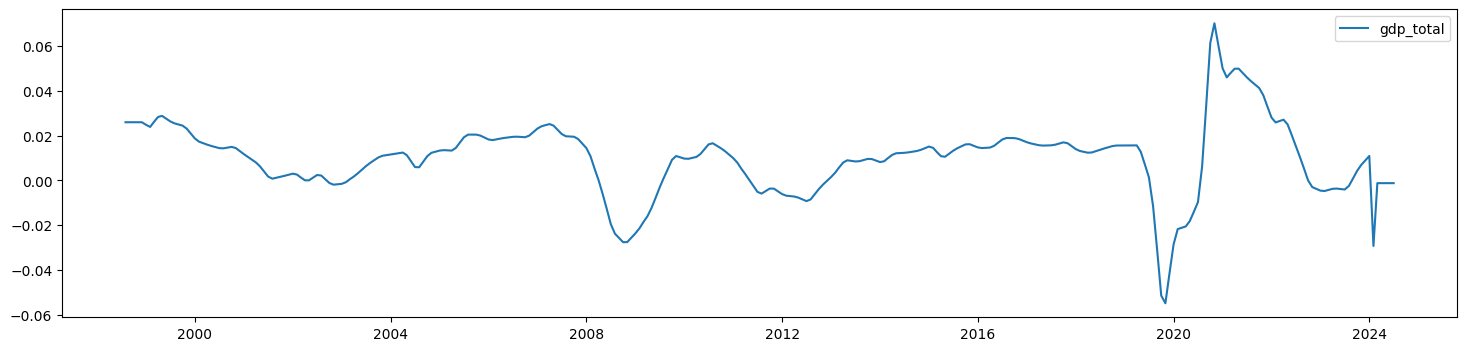

In [3510]:
scaled_features_df_diff[['gdp_total']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [3511]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(313, 66)


In [3512]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

scaled_features_df_diff_lag_subset

,gdp_total,gdp_total_lag_1,^AEX_lag_1,ASML.AS_lag_1,AIR_lag_1,ING_lag_1,WKL.AS_lag_1,Bankruptcies_lag_1,Consumentenvertrouwen_1_lag_1,EconomischKlimaat_2_lag_1,...,Netherlands_unemply_F_lag_1,Netherlands_unemply_M_lag_1,"Natural gas, Europe_lag_1",CCICP_DEU_lag_1,United States_unemply_F_lag_1,United States_unemply_M_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1998-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-01,0.026025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-09-01,0.026025,0.026025,-0.315284,-0.001807,-0.221910,-0.226358,0.047144,-0.495223,-0.133241,-0.114793,...,0.102015,-0.065144,-0.003849,0.135685,-0.014862,-0.010339,-0.172366,0.030676,0.030373,-0.014680
1998-10-01,0.026025,0.026025,-0.425852,-0.004947,-0.214875,-0.483535,0.043892,0.898115,-0.266482,-0.430472,...,0.153023,0.065144,-0.005132,0.108084,-0.014862,-0.010339,0.603524,0.030676,0.030373,-0.014680
1998-11-01,0.026025,0.026025,-0.244786,-0.000162,-0.049788,-0.372749,-0.016696,-0.738637,-0.444136,-0.631360,...,0.000000,0.000000,-0.020530,0.117658,-0.014862,-0.010339,-0.159535,0.030676,0.030373,-0.014680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,-0.001193,-0.029259,0.353628,0.755352,0.383967,-0.164494,0.279013,-0.520403,0.044414,-0.057396,...,0.000000,0.130288,-0.181075,0.158626,-0.038528,0.011648,0.000257,-0.048776,0.113068,0.082294
2024-04-01,-0.001193,-0.001193,0.122973,0.200866,-0.079222,0.380018,0.065538,-0.020984,0.222068,0.172189,...,-0.102015,-0.130288,0.052010,0.232923,0.007427,0.015089,0.279250,-0.000742,0.008242,-0.037930
2024-05-01,-0.001193,-0.001193,0.087919,-0.110626,-0.002251,0.233801,-0.131492,0.344138,0.044414,0.028698,...,-0.051008,-0.065144,0.068183,0.261002,0.007427,0.015089,0.363920,-0.000742,0.008242,-0.037930
2024-06-01,-0.001193,-0.001193,0.185764,-0.058388,0.559416,0.376325,0.213606,-0.352531,-0.044414,-0.114793,...,-0.051008,0.000000,0.133179,0.167010,0.007427,0.015089,-0.215959,-0.000742,0.008242,-0.037930


In [3513]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(313, 30)


[11 17 22 25 27]
['EconomischeSituatieKomende12Maanden_5_lag_1', 'ProducerConfidence_1_lag_1', 'CCICP_NLD_CLI_lag_1', 'Natural gas, Europe_lag_1', 'United States_unemply_F_lag_1']


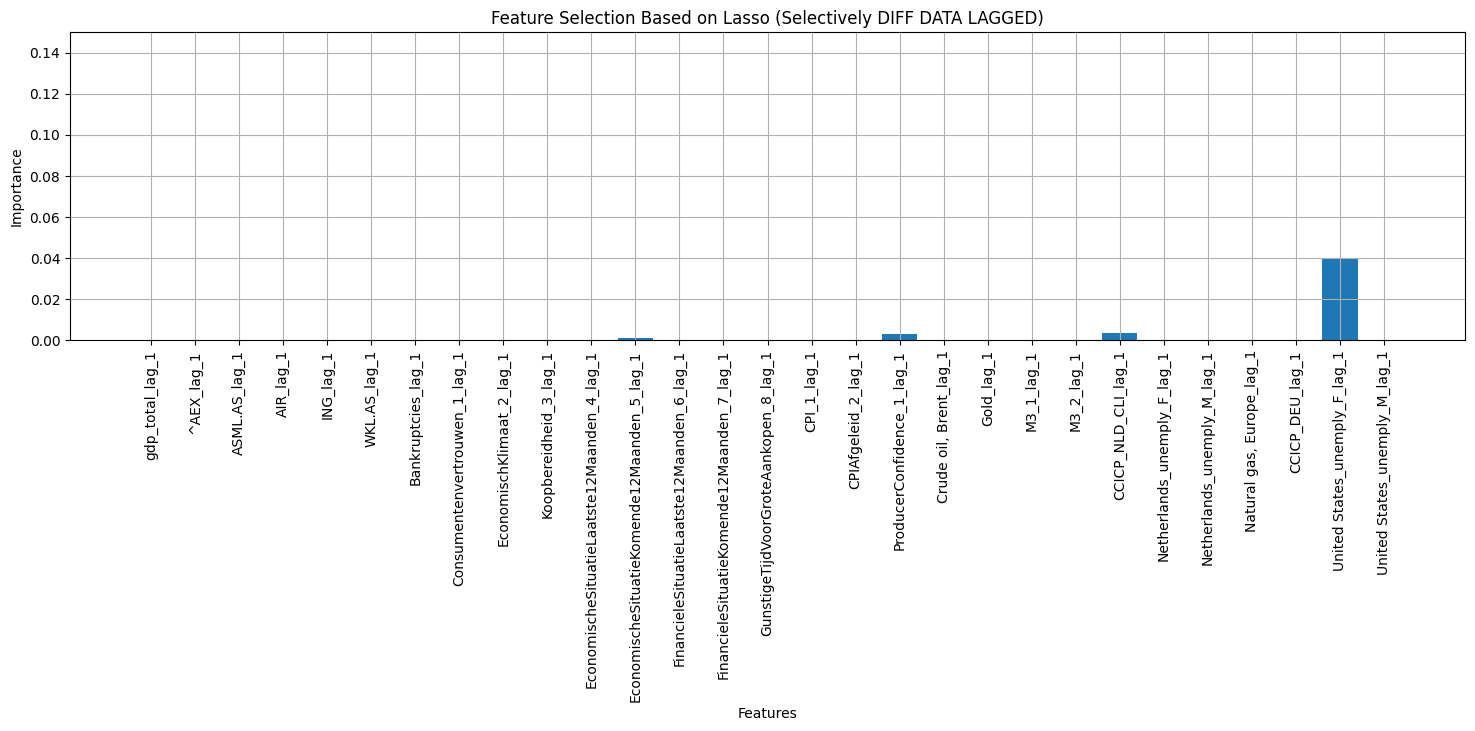

In [3514]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.0005, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

In [3515]:
chooseThese = ['gdp_total'] + lasout
#chooseThese.remove('United States_unemply_F_lag_1')
print(chooseThese)

['gdp_total', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'ProducerConfidence_1_lag_1', 'CCICP_NLD_CLI_lag_1', 'Natural gas, Europe_lag_1', 'United States_unemply_F_lag_1']


In [3516]:
scaled_features_df_diff_lag.shape
scaled_features_df_diff_lag['gdp_total'].shape


(313,)

In [3517]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")
#reg1 = scaled_features_df_diff_lag[['random_0_lag_1', 'random_1_lag_1']]
reg1.dropna(inplace=True)

##################################
test_train_split = 300
##################################


X = reg1.iloc[0:test_train_split, 1:]
X = sm.add_constant(X)

y_true = reg1.iloc[0:test_train_split:, 0]

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


print(scaled_features_df_diff_lag.shape)
scaled_features_df_diff_lag

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     85.12
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           4.46e-55
Time:                        23:22:27   Log-Likelihood:                 949.72
No. Observations:                 300   AIC:                            -1887.
Df Residuals:                     294   BIC:                            -1865.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

,gdp_total,^AEX,ASML.AS,AIR,ING,WKL.AS,Bankruptcies,Consumentenvertrouwen_1,EconomischKlimaat_2,Koopbereidheid_3,...,Netherlands_unemply_F_lag_1,Netherlands_unemply_M_lag_1,"Natural gas, Europe_lag_1",CCICP_DEU_lag_1,United States_unemply_F_lag_1,United States_unemply_M_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1998-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-01,0.026025,-0.315284,-0.001807,-0.221910,-0.226358,0.047144,-0.495223,-0.133241,-0.114793,-0.058800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-09-01,0.026025,-0.425852,-0.004947,-0.214875,-0.483535,0.043892,0.898115,-0.266482,-0.430472,-0.058800,...,0.102015,-0.065144,-0.003849,0.135685,-0.014862,-0.010339,-0.172366,0.030676,0.030373,-0.014680
1998-10-01,0.026025,-0.244786,-0.000162,-0.049788,-0.372749,-0.016696,-0.738637,-0.444136,-0.631360,-0.176401,...,0.153023,0.065144,-0.005132,0.108084,-0.014862,-0.010339,0.603524,0.030676,0.030373,-0.014680
1998-11-01,0.026025,0.430043,0.004898,0.247703,0.406975,0.043631,0.058755,-0.133241,-0.143491,-0.058800,...,0.000000,0.000000,-0.020530,0.117658,-0.014862,-0.010339,-0.159535,0.030676,0.030373,-0.014680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,-0.001193,0.122973,0.200866,-0.079222,0.380018,0.065538,-0.020984,0.222068,0.172189,0.176401,...,0.000000,0.130288,-0.181075,0.158626,-0.038528,0.011648,0.000257,-0.048776,0.113068,0.082294
2024-04-01,-0.001193,0.087919,-0.110626,-0.002251,0.233801,-0.131492,0.344138,0.044414,0.028698,0.058800,...,-0.102015,-0.130288,0.052010,0.232923,0.007427,0.015089,0.279250,-0.000742,0.008242,-0.037930
2024-05-01,-0.001193,0.185764,-0.058388,0.559416,0.376325,0.213606,-0.352531,-0.044414,-0.114793,0.058800,...,-0.051008,-0.065144,0.068183,0.261002,0.007427,0.015089,0.363920,-0.000742,0.008242,-0.037930
2024-06-01,-0.001193,0.103405,0.455374,-0.133042,-0.069117,0.164076,0.142691,-0.044414,0.000000,-0.117600,...,-0.051008,0.000000,0.133179,0.167010,0.007427,0.015089,-0.215959,-0.000742,0.008242,-0.037930


<Axes: >

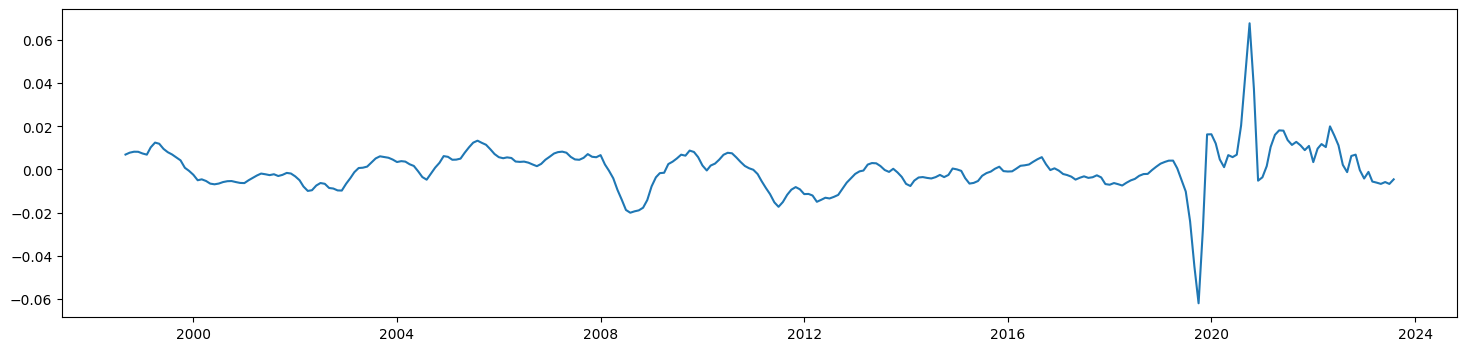

In [3518]:
results.resid.plot()

In [3519]:
ypred = results.predict(X)
Xnew = reg1.iloc[test_train_split:, 1:]
Xnew[['const']] = 1
reg1.iloc[test_train_split:, 0]

2023-09-01    0.000863
2023-10-01    0.004202
2023-11-01    0.006888
2023-12-01    0.008921
2024-01-01    0.010954
2024-02-01   -0.029259
2024-03-01   -0.001193
2024-04-01   -0.001193
2024-05-01   -0.001193
2024-06-01   -0.001193
2024-07-01   -0.001193
Name: gdp_total, dtype: float64

                real  predicted
2023-09-01  0.000863  -0.134877
2023-10-01  0.004202  -0.137040
2023-11-01  0.006888  -0.134093
2023-12-01  0.008921  -0.133504
2024-01-01  0.010954  -0.131603
2024-02-01 -0.029259  -0.131325
2024-03-01 -0.001193  -0.133128
2024-04-01 -0.001193  -0.131654
2024-05-01 -0.001193  -0.132595
2024-06-01 -0.001193  -0.133823
2024-07-01 -0.001193  -0.133115


<Axes: >

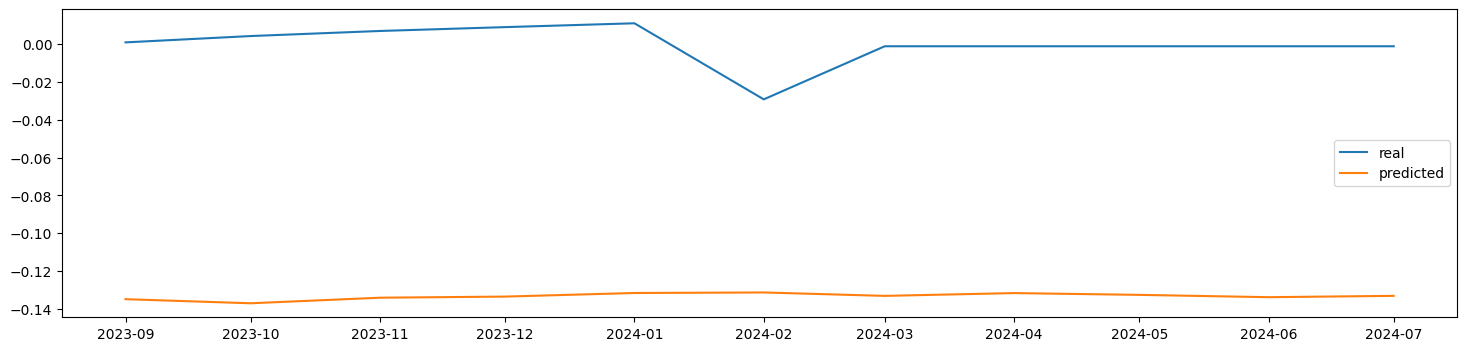

In [3520]:

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.iloc[test_train_split:, 0], 'predicted': ynewpred})
print(df_pred)
df_pred.plot()

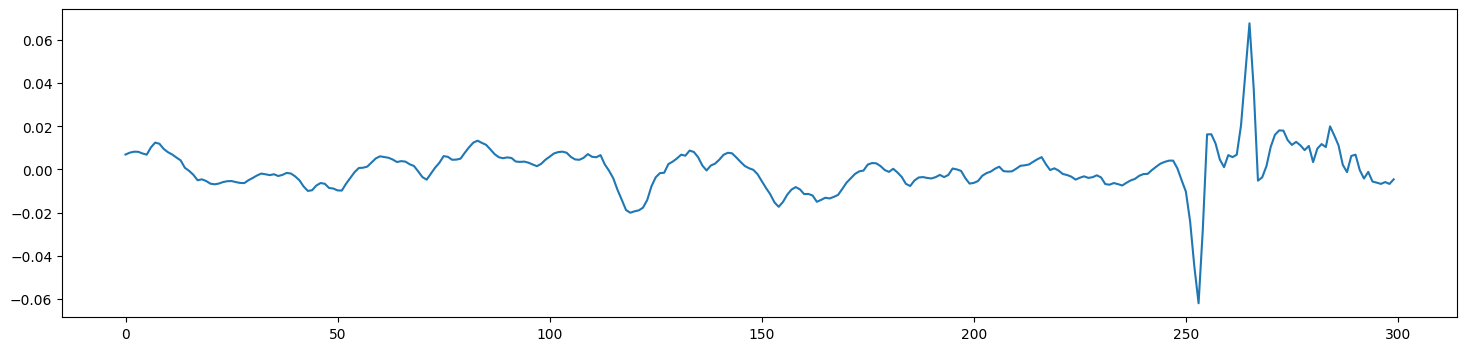

In [3521]:
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Remove Covid for tests

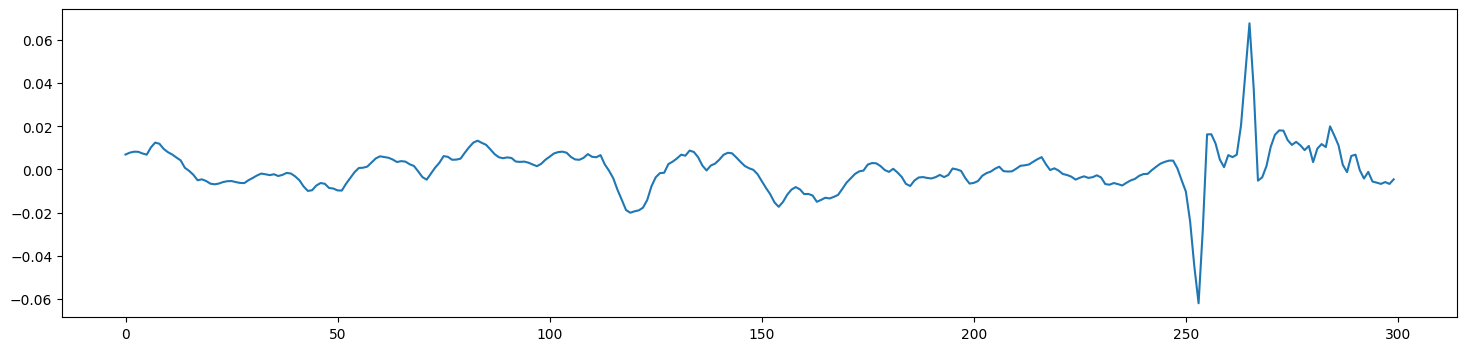

In [3522]:
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Homoskedasticity

In [3523]:
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

Heteroskedasticity (Breusch-Pagan)


In [3524]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Colinearity

In [3525]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

0.31128564685139937
Positive autocorrelation is significant


### Normality

Residuals are not normally distributed


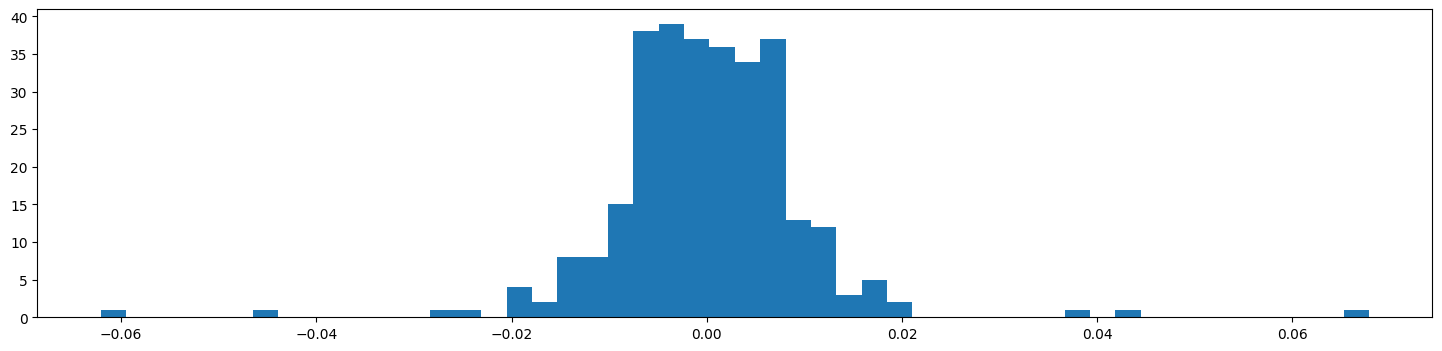

In [3526]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=50);

In [3527]:
GDP_FIRST_VALUE_BEFORE_DIFFERENCE
y_true

1998-09-01    0.026025
1998-10-01    0.026025
1998-11-01    0.026025
1998-12-01    0.026025
1999-01-01    0.024892
                ...   
2023-04-01   -0.003737
2023-05-01   -0.003605
2023-06-01   -0.003822
2023-07-01   -0.004038
2023-08-01   -0.002477
Name: gdp_total, Length: 300, dtype: float64

In [3528]:
std_inv_Transformation(diff_inv_Transformation(scaled_features_df_diff_lag['gdp_total'].dropna(), GDP_FIRST_VALUE_BEFORE_DIFFERENCE.values))

array([151235.51362989, 151933.21856384, 152630.9234978 , 153328.62843175,
       154026.33336571, 154724.03829966, 155391.375     , 156032.73611111,
       156733.65277778, 157494.125     , 158267.91666667, 159008.79166667,
       159716.75      , 160401.34722222, 161072.13888889, 161729.125     ,
       162349.80555556, 162911.68055556, 163414.75      , 163879.625     ,
       164326.91666667, 164756.625     , 165170.84722222, 165571.68055556,
       165959.125     , 166344.22222222, 166738.01388889, 167140.5       ,
       167528.97222222, 167880.72222222, 168195.75      , 168476.16666667,
       168724.08333333, 168939.5       , 169108.11111111, 169215.61111111,
       169262.        , 169283.52777778, 169316.44444444, 169360.75      ,
       169417.06944444, 169486.02777778, 169567.625     , 169638.41666667,
       169674.95833333, 169677.25      , 169678.51388889, 169711.97222222,
       169777.625     , 169836.94444444, 169851.40277778, 169821.        ,
       169770.69444444, 1

In [3529]:
scaled_features_df_diff_lag['gdp_total'].dropna()

1998-08-01    0.026025
1998-09-01    0.026025
1998-10-01    0.026025
1998-11-01    0.026025
1998-12-01    0.026025
                ...   
2024-03-01   -0.001193
2024-04-01   -0.001193
2024-05-01   -0.001193
2024-06-01   -0.001193
2024-07-01   -0.001193
Name: gdp_total, Length: 312, dtype: float64